In [1]:
!pip install -q pytorch-widedeep
!pip install -q scikit-learn pandas matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import cv2
from sklearn.model_selection import train_test_split

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy

In [3]:
import torch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print((f'Using device: {device}'))

Using device: cuda


In [4]:
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=";", on_bad_lines='warn', encoding="latin-1")
books = pd.read_csv("BX-Books.csv", sep=';', encoding='latin-1', on_bad_lines='skip')
users = pd.read_csv("BX-Users.csv", sep=";", on_bad_lines='warn', encoding="latin-1")

/tmp/ipykernel_7403/1272429180.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("BX-Books.csv", sep=';', encoding='latin-1', on_bad_lines='skip')


In [5]:
print(users.columns)
print(books.columns)
print(ratings.columns)

Index(['User-ID', 'Location', 'Age'], dtype='object')
Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')


In [6]:
print(users.shape)
print(books.shape)
print(ratings.shape)

(278858, 3)
(271360, 8)
(1149780, 3)


In [7]:
books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)


In [8]:
print(users.columns)
print(books.columns)
print(ratings.columns)

Index(['User-ID', 'Location', 'Age'], dtype='object')
Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher'],
      dtype='object')
Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')


In [9]:
data = pd.merge(ratings, books, on='ISBN', how='inner')
data = pd.merge(data, users, on='User-ID', how='inner')


In [10]:
data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,"seattle, washington, usa",NaN
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,"h, new south wales, australia",16.0
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,"rijeka, n/a, croatia",16.0


In [11]:
data.isnull().sum()

User-ID                     0
ISBN                        0
Book-Rating                 0
Book-Title                  0
Book-Author                 2
Year-Of-Publication         0
Publisher                   2
Location                    0
Age                    277835
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  int64  
 3   Book-Title           1031136 non-null  object 
 4   Book-Author          1031134 non-null  object 
 5   Year-Of-Publication  1031136 non-null  object 
 6   Publisher            1031134 non-null  object 
 7   Location             1031136 non-null  object 
 8   Age                  753301 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 70.8+ MB


In [13]:
num_users = data['User-ID'].nunique()
num_books = data['ISBN'].nunique()
print(f"Number of users: {num_users}")
print(f"Number of books: {num_books}")


Number of users: 92106
Number of books: 270151


In [14]:
country = data['Location'].apply(lambda row: str(row).split(',')[-1])
data.groupby(country)['Book-Rating'].count().sort_values(ascending=False).head(10)

Location
 usa               746466
 canada             93000
 united kingdom     33072
 germany            27657
                    24259
 australia          18238
 spain              14968
 n/a                11177
 france             10639
 portugal            6980
Name: Book-Rating, dtype: int64

In [15]:
print('Size of the dataset is: ', data.memory_usage().sum() / 1024**2, ' MB')

Size of the dataset is:  70.8026123046875  MB


In [16]:
print('Missing data [%]')
round(data.isnull().sum() / len(data) * 100, 4)

Missing data [%]


User-ID                 0.0000
ISBN                    0.0000
Book-Rating             0.0000
Book-Title              0.0000
Book-Author             0.0002
Year-Of-Publication     0.0000
Publisher               0.0002
Location                0.0000
Age                    26.9446
dtype: float64

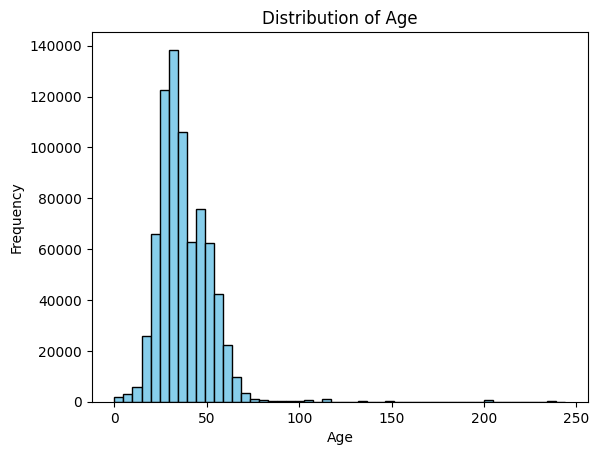

In [17]:
import matplotlib.pyplot as plt

plt.hist(data['Age'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [18]:
median_age = data['Age'].median()
data.loc[data['Age'] > 100, 'Age'] = median_age

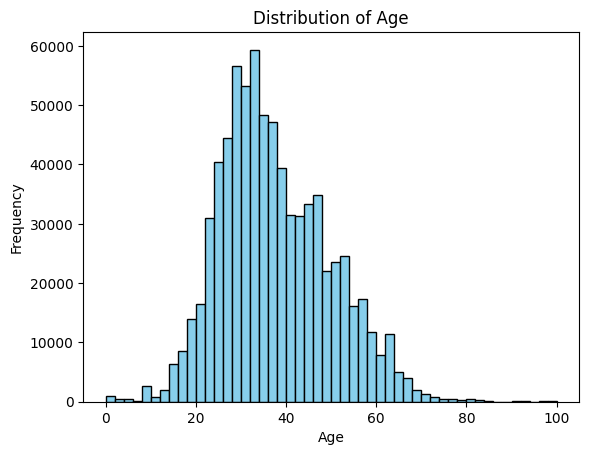

In [19]:
import matplotlib.pyplot as plt

plt.hist(data['Age'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [20]:
data.isnull().sum()

User-ID                     0
ISBN                        0
Book-Rating                 0
Book-Title                  0
Book-Author                 2
Year-Of-Publication         0
Publisher                   2
Location                    0
Age                    277835
dtype: int64

In [21]:
data['Age'].fillna(data['Age'].median(), inplace=True)

/tmp/ipykernel_7403/913469570.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)


<Axes: xlabel='Book-Rating', ylabel='count'>

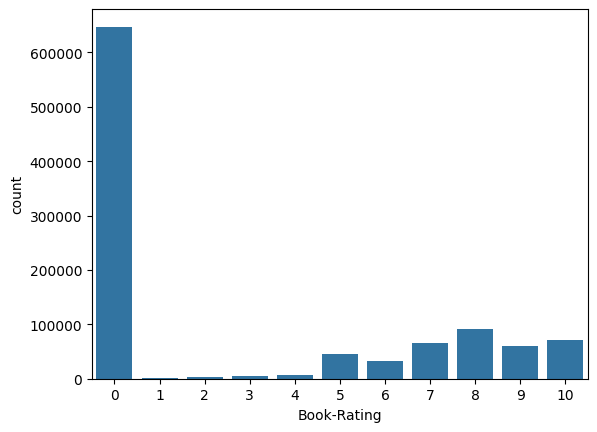

In [22]:
import seaborn as sns
sns.countplot(x='Book-Rating', data=data)

In [23]:
data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'Location', 'Age'],
      dtype='object')

In [24]:
data['Year-Of-Publication'] = pd.to_datetime(data['Year-Of-Publication'], errors='coerce').dt.year.fillna(0).astype(int)


In [25]:
data[['City', 'State', 'Country']] = data['Location'].str.split(', ', expand=True, n=2).fillna('')

In [26]:
data.drop('Location', axis=1, inplace=True)

In [27]:
data.head().T

,0,1,2,3,4
User-ID,276725,276726,276727,276729,276729
ISBN,034545104X,0155061224,0446520802,052165615X,0521795028
Book-Rating,0,5,0,3,6
Book-Title,Flesh Tones: A Novel,Rites of Passage,The Notebook,Help!: Level 1,The Amsterdam Connection : Level 4 (Cambridge ...
Book-Author,M. J. Rose,Judith Rae,Nicholas Sparks,Philip Prowse,Sue Leather
Year-Of-Publication,1970,2001,1970,1999,2001
Publisher,Ballantine Books,Heinle,Warner Books,Cambridge University Press,Cambridge University Press
Age,35.0,35.0,16.0,16.0,16.0
City,tyler,seattle,h,rijeka,rijeka
State,texas,washington,new south wales,n/a,n/a


In [28]:
data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,1970,Ballantine Books,35.0,tyler,texas,usa
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,35.0,seattle,washington,usa
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1970,Warner Books,16.0,h,new south wales,australia
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,16.0,rijeka,n/a,croatia
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,16.0,rijeka,n/a,croatia


In [29]:
# Define the 'column set up'
wide_cols = [
    "Book-Title",
    "Book-Author",
    "Publisher",
    "Year-Of-Publication",
    "City",
    "Age",
]
crossed_cols = [("Book-Title", "Book-Author"), ("City", "Book-Author")]

cat_embed_cols = [
    "Publisher",
    "Book-Title",
    "Book-Rating",
    "Book-Author",
    "Year-Of-Publication",
    "City",
    "Country",
]
continuous_cols = ["Age"]
target = "Book-Rating"


In [30]:
df_train, df_test = train_test_split(data, test_size=0.3)

In [31]:
target = df_train[target].values

In [32]:
# prepare the data
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df_train)

tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(df_train)

/opt/conda/lib/python3.10/site-packages/pytorch_widedeep/preprocessing/tab_preprocessor.py:360: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


In [33]:
# build the model
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=1)
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
)


In [34]:
num_classes = data['Book-Rating'].nunique()
print(num_classes)

11


In [35]:
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=num_classes)
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols
)

model = WideDeep(wide=wide, deeptabular=tab_mlp, pred_dim=num_classes)

In [36]:
# train and validate
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy])
trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=3,
    batch_size=64,
)

epoch 3: 100%|██████████| 11279/11279 [04:16<00:00, 43.95it/s, loss=0.0031, metrics={'acc': 0.9996}] 


In [37]:
# predict on test
X_wide_te = wide_preprocessor.transform(df_test)
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_wide=X_wide_te, X_tab=X_tab_te)

predict: 100%|██████████| 4834/4834 [00:12<00:00, 397.44it/s]


In [39]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(df_test['Book-Rating'].values, preds)
print(f"Accuracy on Test Data: {acc*100}%")

Accuracy on Test Data: 99.95635884024426%


In [40]:
# Option 2: save as any other torch model
torch.save(model.state_dict(), "wd_model.pt")